___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2024

___
### Import libraries and sub-libraries.

In [185]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import tifffile 

___
### Check the hardware that is at your disposal

In [186]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cpu


___
### Read training data from `data/train-clean-tif`


In [187]:
# Loading TIFF images
class TIFFDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path)
        if self.transform: # Dynamically apply data transformation
            image = self.transform(image)
        return image

# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('train-clean-tif', transform=transform)

# Function to create data loader
def create_loader(train_dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility of random numbers in PyTorch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creates a training DataLoader from this Dataset
    return train_loader

dataset_size = len(train_dataset)
print('Number of images in the dataset:', dataset_size)


Number of images in the dataset: 52


___
### Define a denoising network

#### Here, I have defined a trivial network, which has only one convolutional layer and no activation function. We are essentially doing linear filtering.

In [188]:
# class TrivialNet(nn.Module):
#     def __init__(self):
#         super(TrivialNet, self).__init__()
#         self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

#     def forward(self, x):
#         x = self.conv(x)
#         return x

In [189]:
class JNet(nn.Module):
    def __init__(self):
        super(JNet, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
#         # self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

#         self.conv5 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
#         self.conv6 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
#         self.conv7 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
#         self.conv8 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

#         # self.bn1 = nn.BatchNorm2d(16)
#         # self.bn2 = nn.BatchNorm2d(32)
#         # self.bn3 = nn.BatchNorm2d(64)
#         # self.bn4 = nn.BatchNorm2d(128)
#         # self.bn5 = nn.BatchNorm2d(64)
#         # self.bn6 = nn.BatchNorm2d(32)
#         # self.bn7 = nn.BatchNorm2d(16)

#         self.conv_transpose1 = nn.ConvTranspose2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, output_padding=0)
#         self.conv_transpose2 = nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, output_padding=0)
#         self.conv_transpose3 = nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, output_padding=0)
      

#         #conv tranposed to upsample

#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         print("input shape:", x.shape)

#         x = self.conv1(x)
#         print("Conv1 output shape:", x.shape)
#         # x = self.bn1(x)
#         x = self.relu(x)
#         x = self.pool(x)
   

#         x = self.conv2(x)
#         print("Conv2 output shape:", x.shape)
#         # x = self.bn2(x)
#         x = self.relu(x)
#         x = self.pool(x)
        

#         x = self.conv3(x)
#         print("Conv3 output shape:", x.shape)
#         # x = self.bn3(x)
#         x = self.relu(x)
#         x = self.pool(x)
        

#         x = self.conv4(x)
#         print("Conv4 output shape:", x.shape)
#         # x = self.bn4(x)
#         x = self.relu(x)
        

#         x = self.conv5(x)
#         print("Conv5 output shape:", x.shape)
#         # x = self.bn5(x)
#         x = self.relu(x)
        

#         x = self.conv6(x)
#         print("Conv6 output shape:", x.shape)
#         # x = self.bn6(x)
#         x = self.relu(x)
       
#         x = self.conv7(x)
#         print("Conv7 output shape:", x.shape)
#         # x = self.bn7(x)
#         x = self.relu(x)

#         x = self.conv8(x)
#         print("Conv8 output shape:", x.shape)
#         x = self.relu(x)

#         x = self.conv_transpose1(x)
#         x = self.relu(x)
#         x = self.conv_transpose2(x)
#         x = self.relu(x)
#         x = self.conv_transpose3(x)
#         x = self.relu(x)

# Encoder (feature extraction)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling

        # Decoder (reconstruction)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)  # Upsampling
        self.relu3 = nn.ReLU(inplace=True)

        self.conv4 = nn.ConvTranspose2d(16,1, kernel_size=3, padding=1)
        # self.relu4 = nn.ReLU(inplace=True)

        # Activation function (optional)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        # x = self.relu4(x)
        return x
    
#         return x

___
### Create a function to execute training. Note, we will call this function later.

In [190]:
def train_model(model, opt, criterion, train_loader, num_epoch, noise_std):
    avg_train_losses = []

    for epoch in range(num_epoch): # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0
        for i, y_tr_batch in enumerate(train_loader): # Loop over mini-batches
            noise = torch.randn_like(y_tr_batch) * noise_std
            x_tr_batch = y_tr_batch + noise

            opt.zero_grad() # delete previous gradients
            y_hat_tr_batch = model(x_tr_batch) # forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch) # compute loss
            loss.backward() # backward pass
            opt.step() # update weights
            total_train_loss += loss.item() # accumulate loss
            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader) # compute average loss
        avg_train_losses.append(avg_train_loss) # accumulate average loss

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch+1), avg_train_losses, label='training loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE loss')
    ax.set_yscale('log')  # Set the vertical axis to log scale
    ax.set_title('training loss')
    ax.grid(True)
    ax.legend()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

In [191]:
batch_size = 2  # Number of complete images in each batch
lr = 1e-3  # Learning rate
sig = 0.1  # Noise std
num_epoch = 3  # Epochs

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
model = JNet() # Pick a model
opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
criterion = nn.MSELoss() # Pick a loss function

# Let's train the model
train_model(model, opt, criterion, train_loader, num_epoch, noise_std=sig)

RuntimeError: The size of tensor a (128) must match the size of tensor b (256) at non-singleton dimension 3

In [ ]:
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images
val_clean = val_dataset[0] # Load one clean image from the validation dataset
val_noisy = ((val_clean + (torch.randn_like(val_clean) * sig))).unsqueeze(0) # Add noise to the clean image
val_denoised = model(val_noisy).detach() # Denoise the noisy image using the trained model

In [ ]:
# def train_model(model, opt, criterion, train_loader, val_loader, num_epoch, noise_std):
#     avg_train_losses = []
#     avg_nmse_losses = []
#     val_nmse_per_epoch = []  # List to store validation NMSE per epoch

#     avg_train_ssim_losses = [] 
#     val_ssim_per_epoch = [] 

#     for epoch in range(num_epoch):
#         model.train()
#         total_train_loss = 0
#         total_nmse_loss = 0

#         total_ssim_loss = 0
#         avg_batch_train_nmse_loss = 0
#         avg_batch_train_ssim_loss = 0

#         for i, y_tr_batch in enumerate(train_loader):
#             # Train with noisy data
#             noise = torch.randn_like(y_tr_batch) * noise_std
#             x_tr_batch = y_tr_batch + noise
            
#             # rand_speckle = np.random.uniform(0.01, 0.05)
#             # x_tr_batch = add_mixed_noise(y_tr_batch, 0.1, rand_speckle)

#             opt.zero_grad()
#             y_hat_tr_batch = model(x_tr_batch)
#             # print(y_hat_tr_batch.shape)
#             loss = criterion(y_hat_tr_batch, y_tr_batch)
#             loss.backward()
#             opt.step()
#             # print(y_tr_batch.shape)
#             total_train_loss += loss.item()

#             # calculate loss of the batch
#             num_batch = y_hat_tr_batch.shape[0]
#             for j in range(num_batch):
#                 total_nmse_loss += calculateNMSE(y_tr_batch[j], y_hat_tr_batch[j])
#                 total_ssim_loss += calculateSSIM(y_tr_batch[j], y_hat_tr_batch[j])

#             avg_batch_train_nmse_loss = total_nmse_loss / num_batch
#             avg_batch_train_ssim_loss = total_ssim_loss / num_batch

#             if (i + 1) % 10 == 0:
#                 print(f'Epoch {epoch+1}, Iteration {i+1}, '
#                       f'MSE: {loss.item():.6f}')

#         avg_train_loss = total_train_loss / len(train_loader)
#         avg_train_losses.append(avg_train_loss)

#         avg_nmse_loss = avg_batch_train_nmse_loss / len(train_loader)
#         avg_nmse_losses.append(avg_nmse_loss)

#         avg_train_ssim_loss = avg_batch_train_ssim_loss / len(train_loader)
#         avg_train_ssim_losses.append(avg_train_ssim_loss)

#         # Calculate validation NMSE per epoch
#         val_epoch_nmse = 0
#         val_epoch_ssim = 0
#         avg_batch_val_nmse = 0
#         avg_batch_val_ssim = 0


#         for y_val_batch in val_loader:
#             noise_val = torch.randn_like(y_val_batch) * noise_std
#             x_val_batch = y_val_batch.detach() + noise_val

#             # rand_speckle = np.random.uniform(0.01, 0.05)
#             # x_val_batch = add_mixed_noise(y_tr_batch, 0.1, rand_speckle)

#             y_hat_val_batch = model(x_val_batch)
#             # print(y_hat_val_batch.shape)
#             num_batch = y_hat_val_batch.shape[0]
#             for j in range(num_batch):
#                 val_epoch_nmse += calculateNMSE(y_val_batch[j], y_hat_val_batch[j])
#                 val_epoch_ssim += calculateSSIM(y_val_batch[j], y_hat_val_batch[j])
            
#             avg_batch_val_nmse = val_epoch_nmse / num_batch
#             avg_batch_val_ssim = val_epoch_ssim / num_batch
                
#         val_nmse_per_epoch.append(avg_batch_val_nmse / len(val_loader))
#         val_ssim_per_epoch.append(avg_batch_val_ssim / len(val_loader))

#     # Plotting (combine training and validation NMSE on same plot)
#     fig, ax = plt.subplots(2,1,figsize=(7, 6))
#     epochs = range(1, num_epoch + 1)  # X-axis for training NMSE

#     # ax[0].plot(epochs, avg_train_losses, label='Training')

#     # ax[0].set_xlabel('Epochs')
#     # ax[0].set_ylabel('MSE Loss')
#     # # No need for log scale here, adjust based on your needs
#     # ax[0].set_title('Training MSE')
#     # ax[0].grid(True)
#     # ax[0].legend()

#     ax[0].plot(epochs, avg_nmse_losses, label='Training')
#     ax[0].plot(epochs, val_nmse_per_epoch, label='Validation')

#     ax[0].set_xlabel('Epochs')
#     ax[0].set_ylabel('NMSE Loss')
#     # No need for log scale here, adjust based on your needs
#     ax[0].set_title('Training and Validation NMSE')
#     ax[0].grid(True)
#     ax[0].legend()

#     ax[1].plot(epochs, avg_train_ssim_losses, label='Training')
#     ax[1].plot(epochs, val_ssim_per_epoch, label='Validation')

#     ax[1].set_xlabel('Epochs')
#     ax[1].set_ylabel('SSIM')
#     # No need for log scale here, adjust based on your needs
#     ax[1].set_title('Training and Validation SSIM')
#     ax[1].grid(True)
#     ax[1].legend()

#     plt.tight_layout()
#     plt.show()

#     batch_size = 2 # Number of complete images in each batch
# lr = 1e-3  # Learning rate
# sig = 0.1  # Noise std
# num_epoch = 2  # Epochs

# # Model, criterion, and optimizer
# train_loader = create_loader(train_dataset, batch_size)
# val_loader = create_loader(val_dataset, batch_size)

# model = JNet() # Pick a model
# opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
# criterion = nn.MSELoss() # Pick a loss function

# # Let's train the model
# train_model(model, opt, criterion, train_loader, val_loader, num_epoch, noise_std=sig)

___
### Apply it to one of the validation image

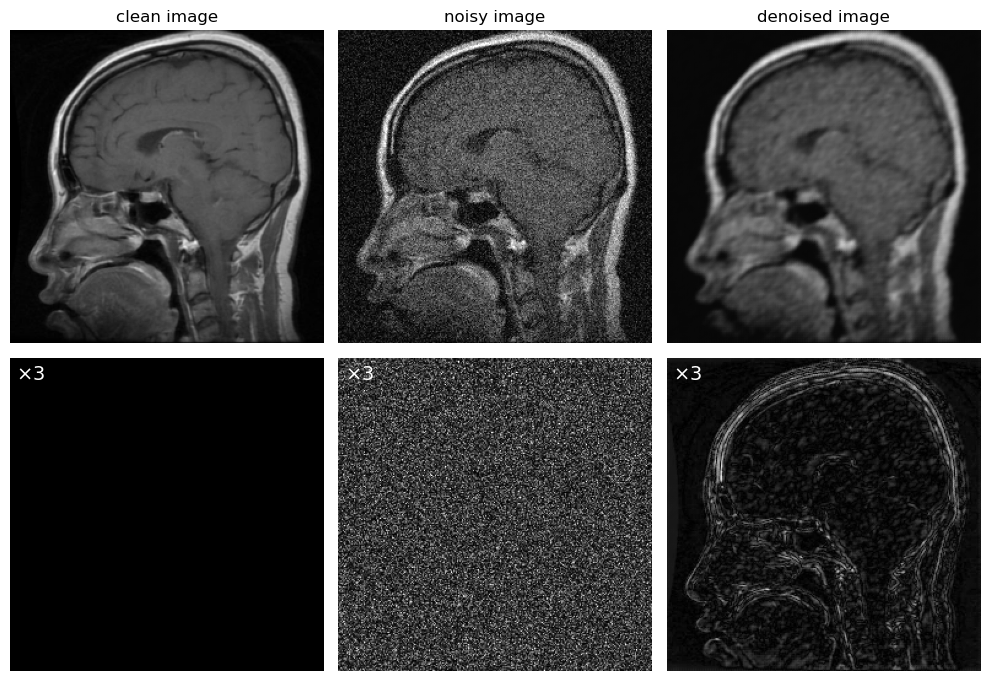

In [ ]:
# Your existing code to generate the figure and axes
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot clean image
ax[0, 0].imshow(np.abs(val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('clean image')
ax[0, 0].axis('off')

# Plot noisy image
ax[0, 1].imshow(np.abs(val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('noisy image')
ax[0, 1].axis('off')

# Plot denoised image
ax[0, 2].imshow(np.abs(val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('denoised image')
ax[0, 2].axis('off')

# Plot corresponding error images
ax[1, 0].imshow(3*np.abs(val_clean - val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(3*np.abs(val_clean - val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(3*np.abs(val_clean - val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')


plt.tight_layout()
plt.show()


In [ ]:
print(val_noisy.shape)

torch.Size([1, 1, 256, 256])


### Calculating NMSE and SSIM

In [ ]:
from skimage.metrics import structural_similarity as ssim

def calculateNMSE(im_denoised,im_clean):
    num = torch.sqrt(torch.sum((im_denoised-im_clean)**2))
    denom = torch.sqrt(torch.sum(im_clean**2))
    NMSE = 20*torch.log10(num/denom)
    return NMSE.detach().item()

# def calculatNMSE(im_clean,im_denoised):
#     mse = torch.sqrt(torch.sum((im_clean-im_denoised)**2))
#     nmse = mse / torch.sqrt(torch.sum(im_clean**2))
#     return 20*np.log10(nmse.detach().item())

# def calculatNMSE(im_denoised,im_clean):
#     num = torch.norm(im_denoised-im_clean)
#     denom = torch.norm(im_clean)
#     NMSE_2 = 20*torch.log10(num/denom)
#     return NMSE_2

NMSE_val = calculateNMSE(val_denoised,val_clean)
print(f'NMSE: {NMSE_val:0.3f}')

# NMSE_val_mihir = calculatNMSE(val_clean,val_denoised)
# print(f'NMSE: {NMSE_val_mihir:0.5f}')

def calculateSSIM(im_clean, im_denoised):

    im_clean = np.abs(im_clean.detach()).squeeze().numpy()
    im_denoised = np.abs(im_denoised.detach()).squeeze().numpy()
    im_range = np.max(im_clean) - np.min(im_clean)

    return ssim(im_clean, im_denoised, data_range=im_range)

SSIM = calculateSSIM(val_clean,val_denoised)
print(f'SSIM: {SSIM:0.3f}')

NMSE: -16.671
SSIM: 0.784


In [ ]:
# Grade Calculation Code
NMSE_te = 0
NMSE_te_sum = 0
for val_clean in val_dataset:
    # add random noise
    val_noisy = val_clean + (torch.randn_like(val_clean) * sig)

    # remove noise with model
    val_denoised = model(val_noisy)

    NMSE_te_sum += calculateNMSE(val_clean, val_denoised)

NMSE_te = NMSE_te_sum / len(val_dataset)


NMSE_ref = -20.7 # change to be max from all teams

grade = min((100 - 5*(NMSE_te - NMSE_ref), 100))

print(f'NMSE: {NMSE_te:0.3f}')
print(f'grade: {grade:0.2f}')

NMSE: -14.134
grade: 67.17


Using 3 epochs (takes 1:12)

8 conv + RELU: -18.275, 0.808

w/out the final RELU with conv8: -17.5347, 0.809

8 conv + RELU + extra conv: -9, 0.711

8 conv + RELU plus extra 1,1 conv + RELU: -9, 0.6

8 conv (8th no RELU) with 7 bns: +10 seconds, plotting error: fix with model(val_noisy.unsqueeze(0)), -13.09, 0.78

original + unsqueeze does not change anything

original for 10 epochs: -19.35393, 0.8294, 4 min, looks like loss hits minimum at 9 epochs

original for 9 epochs: -18.68560, 0.82084

original for 11 epochs: -19.64443, 0.82956, now loss is decreasing again

as of Monday, 19.58 is the number to beat

30 epochs: 13 min, -20.12, 0.85612